# Chatbot Intent Generation and Text Classification



### Overview

In a high-volume ticketing system, one common problem a company might encounter is excess time spent routing tickets and troubleshooting simple issues by tier 1 support agents. A way to deflect this time sink is the introduction of a customer facing chatbot. 


While the development of a chatbot with menus and dialogues is relatively straightforward with interfaces that are readily available in most enterprise ticketing systems, a problem quickly arises: How does the chatbot recognize intent that aligns with all the different things a company supports? When a customer types their issue in the chat box, the bot needs to route the customer to either a group of agents that can help, or a series of triage steps to help them resolve the issue. 


Through the following series of cells, Python code is used to capture text from historical ticket data, generate utterances for a chatbot to recognize, and classify tickets for potential routing automation.  Though this code may be easily modularized and applied to nearly any ticketing system, the publicly available [Consumer Complaint Database]( https://www.consumerfinance.gov/data-research/consumer-complaints/#download-the-data) is used for demonstration purposes.



### Utterance Generation

First, the historical consumer complaint dataset is simply imported with the “Pandas” package and previewed.

In [1]:
#import necessary packages for data manipulation
import pandas as pd
import numpy as np
#import consumer complaint dataset
df = pd.read_csv('complaints.csv')
#preview dataset
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2019-09-24,Debt collection,I do not know,Attempts to collect debt not owed,Debt is not yours,transworld systems inc. \nis trying to collect...,NaN,TRANSWORLD SYSTEMS INC,FL,335XX,NaN,Consent provided,Web,2019-09-24,Closed with explanation,Yes,NaN,3384392
1,2019-09-19,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,PA,15206,NaN,Consent not provided,Web,2019-09-20,Closed with non-monetary relief,Yes,NaN,3379500
2,2019-11-08,Debt collection,I do not know,Communication tactics,Frequent or repeated calls,"Over the past 2 weeks, I have been receiving e...",NaN,"Diversified Consultants, Inc.",NC,275XX,NaN,Consent provided,Web,2019-11-08,Closed with explanation,Yes,NaN,3433198
3,2019-09-15,Debt collection,Other debt,Attempts to collect debt not owed,Debt was result of identity theft,Pioneer has committed several federal violatio...,NaN,Pioneer Capital Solutions Inc,CA,925XX,NaN,Consent provided,Web,2019-09-15,Closed with explanation,Yes,NaN,3374555
4,2019-07-18,Mortgage,Conventional home mortgage,Closing on a mortgage,NaN,I started the process to refinance my current ...,Company has responded to the consumer and the ...,Freedom Mortgage Company,NC,275XX,NaN,Consent provided,Web,2019-07-18,Closed with explanation,Yes,NaN,3311105


With a brief inspection of the first five rows of data above, two columns stand out for the task at hand. For text that originated from a customer’s input, the `Consumer complaint narrative` column is readily available. Secondly, the `Product` column appears to identify discrete categories of each consumer complaint. 

To ensure these categories represent the data well, the sum of values for each `Product` category are previewed below. Although some categories like `Virtual currency` have low value counts, this distribution is sufficient for predictive inference. 

In [2]:
#show value counts for `Product`
df['Product'].value_counts()

Credit reporting, credit repair services, or other personal consumer reports    616119
Debt collection                                                                 330393
Mortgage                                                                        318133
Credit reporting                                                                140432
Credit card or prepaid card                                                      99623
Credit card                                                                      89190
Bank account or service                                                          86206
Checking or savings account                                                      80171
Student loan                                                                     60298
Consumer Loan                                                                    31604
Money transfer, virtual currency, or money service                               22117
Vehicle loan or lease                      

Now that the ` Consumer complaint narrative` and `Product` columns are identified, the dataset is trimmed and cleaned for text classification. In the following cell, five cleaning and preparation steps need to be performed.
>1. The ` Complaint ID` is set as the index in case predictive values need to be referenced in the database later.
>2. The dataset is trimmed to only include the ` Consumer complaint narrative` and `Product` columns.
>3. All duplicate rows and rows with any missing values are removed.
>4. A ` Product_id` column is created as a numerical representation of ` Product` for increased mathematical efficiency in later classification. 
>5. All words that contain special characters and numbers are removed from the ` Consumer complaint narrative`. This way, noise from dates and non-English words are removed from the data.


In [3]:
#set case id as index
df.set_index('Complaint ID', inplace=True)
#only keep `Product` and `Consumer complaint narrative` columns 
df = df[['Product','Consumer complaint narrative']]
#drop any rows with null values
df.dropna(inplace=True)
#drop any entirely duplicate rows
df.drop_duplicates(inplace=True)
#create id for Products
df['Product_id'] = df['Product'].factorize()[0]
#create dataframe for `Product_id` reference dictionaries
product_id_df = df[['Product', 'Product_id']].drop_duplicates().sort_values('Product_id')
#create two inverse dictionaries from product_id_df
product_to_id = dict(product_id_df.values)
id_to_product = dict(product_id_df[['Product_id','Product']].values)
#remove any text that contains characters or digits to reduce noise
df['Consumer complaint narrative'] = df['Consumer complaint narrative'].str.replace(r"\S*(\d+)|([$&+,:;=?@#'<>.^*()%!-]+)\S*", '', regex=True)
#preview prepared dataset
df.head()

,Product,Consumer complaint narrative,Product_id
Complaint ID,,,
3384392,Debt collection,transworld systems inc \nis trying to collect ...,0
3433198,Debt collection,Over the past weeks I have been receiving exc...,0
3374555,Debt collection,Pioneer has committed several federal violatio...,0
3311105,Mortgage,I started the process to refinance my current ...,1
3319331,"Credit reporting, credit repair services, or o...",Previously on XX/XX/XXXX XX/XX/XXXX and XX/XX/...,2


Finally, as displayed above, we have a dataset that contains only the information needed for text classification and utterance generation. 

In the next cell, the `Consumer complaint narrative` column is transformed into a matrix of vectors that numerically represent each one-word, two-word, and three-word term in the text. This way, the Chi-Squared statistic for each term can be used to find the most correlated terms for each `Product` category. 

Below the code cell, an output of the top five most correlated each one-word, two-word, and three-word terms respectively for each `Product` are displayed in a Python dictionary. 

In [4]:
#Import packages
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
#define length of longest phrase
max_length = 3
#create scikit learn text vecorizer
vectorizer = TfidfVectorizer(sublinear_tf=True, 
                            min_df=5, 
                            norm='l2', 
                            encoding='latin-1', 
                            ngram_range=(1, max_length),
                            stop_words='english')
#fit vectorizer to text data
x = vectorizer.fit_transform(df['Consumer complaint narrative'])

#find chi-squared statistic for each term and subtype
#define output dictionary
product_term_dict = {}
#define number of highest chi2 terms to save
number_of_terms = 5
#loop through each Product
for Product, Product_id in sorted(product_to_id.items()):
    #calculate chi-squared for each word vs Product
    x_chi2 = chi2(x, df['Product_id'] == Product_id)
    #sort chisquared values
    indices = np.argsort(x_chi2[0])
    x_names = np.array(vectorizer.get_feature_names())[indices]
    unigrams = [i for i in x_names if len(i.split(' ')) == 1]
    product_term_dict[Product] = [unigrams[-number_of_terms:]]
    for j in range(2, max_length+1):
        ngrams = [i for i in x_names if len(i.split(' ')) == j]
        product_term_dict[Product].append(ngrams[-number_of_terms:])

#print resulting dictionary of most correlated terms
product_term_dict

{'Bank account or service': [['checking',
   'scottrade',
   'bank',
   'citigold',
   'overdraft'],
  ['xxxx overdraft',
   'overdraft fee',
   'citigold checking',
   'checking account',
   'overdraft fees'],
  ['charged overdraft fee',
   'xxxx xxxx miles',
   'opened citigold checking',
   'xxxx overdraft fees',
   'citigold checking account']],
 'Checking or savings account': [['overdraft',
   'bank',
   'branch',
   'checking',
   'deposit'],
  ['direct deposit',
   'overdraft fees',
   'debit card',
   'savings account',
   'checking account'],
  ['charged overdraft fees',
   'days account opening',
   'business checking account',
   'opened checking account',
   'checking savings account']],
 'Consumer Loan': [['dealership', 'dealer', 'ally', 'vehicle', 'car'],
  ['dealer services', 'car loan', 'vehicle xxxx', 'drive time', 'auto loan'],
  ['statement did payments',
   'did payments misapplied',
   'santander consumer usa',
   'wells fargo dealer',
   'fargo dealer services']],

With brief inspection of the dictionary output above, it makes sense why each term might be correlated with each `Product`. For example, `direct deposit` and `charged overdraft fees` a have the highest Chi-Squared association with the `Checking or savings account` category. 

Next, each of these terms is concatenated with a series of pronouns, help phrases, and actions to form a series of utterances like what a customer might ask from a chatbot.

In [5]:
#define loop to generate utterances
def create_utterances(pronouns, 
                      help_phrases, 
                      actions, 
                      product_term_dict):
    '''
    takes most correlated phrases per category created from find_most_correlated()
    and created a dictionary of utterances from specified lists of pronouns, 
    help_phrases and actions
    '''
    utt_dict = {}
    for key in list(product_term_dict.keys()):
        utt_dict[key] = []
        for value_list in range(len(product_term_dict[key])):
            for value in range(len(product_term_dict[key][value_list])):
                for pronoun in pronouns:
                    for help_phrase in help_phrases:
                        for action in actions:
                            utterance = pronoun+' '+help_phrase+' '+action+' '+(product_term_dict[key][value_list][value])
                            utt_dict[key].append(utterance)
    global utterance_dict
    utterance_dict = utt_dict

#define pronouns, help phrases and actions to use
pronouns = ['I', 'i']
help_phrases = ['would like', 'want', 'need']
actions = ['help with the', 'assistance with the', 'help with', 'assistance with']
#create dictionary of utterances
create_utterances(pronouns, help_phrases, actions, product_term_dict)

#print utterances for `Student loan` Product to preview results
utterance_dict['Student loan']

['I would like help with school',
 'I would like assistance with school',
 'I want help with school',
 'I want assistance with school',
 'I need help with school',
 'I need assistance with school',
 'i would like help with school',
 'i would like assistance with school',
 'i want help with school',
 'i want assistance with school',
 'i need help with school',
 'i need assistance with school',
 'I would like help with repayment',
 'I would like assistance with repayment',
 'I want help with repayment',
 'I want assistance with repayment',
 'I need help with repayment',
 'I need assistance with repayment',
 'i would like help with repayment',
 'i would like assistance with repayment',
 'i want help with repayment',
 'i want assistance with repayment',
 'i need help with repayment',
 'i need assistance with repayment',
 'I would like help with student',
 'I would like assistance with student',
 'I want help with student',
 'I want assistance with student',
 'I need help with student',
 'I

Although not every utterance output above is a perfect representation of what a customer may say, if the natural language processing algorithm that the chatbot uses is able to generalize well, they are good enough for an initial training. 

From this dictionary of utterances, the chatbot is initially trained with the ability to generalize approximate categories of help that a customer may need. Through time, the chatbot’s intent recognition model may be recursively refined with actual utterances from real end users. 

### Text Classification

With a successful output of utterances for training a chatbot’s intent, there is yet another easily attainable insight of value from the data at hand.  Recall that to find the most correlated terms for each `Product` a matrix of one-word, two-word, and three-word terms was created. With this same matrix, a model can be trained with a few lines of code that can classify help tickets. Perhaps in an enterprise ticketing system, classification of consumer complaints could help in reducing misrouted tickets, and if accurate enough, route the tickets automatically.

Below, the Scikit Learn package is used to train a support vector machine algorithm to classify each consumer complaint into the correct `Product` on 70% of the data. Then, predictions are performed from the resulting model on 30% of the data. Below the cell, an accuracy score is printed which represents the percentage of correct `Product` predictions.

In [6]:
#import necessary packages
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

#split data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, df['Product_id'], test_size=0.3, random_state=42)
#define model
model = LinearSVC()
#train model
model.fit(x_train, y_train)
#test model
y_pred = model.predict(x_test)

#print model accuracy score
print('Model Accuracy: {}'.format(accuracy_score(y_test, y_pred)))


Model Accuracy: 0.7896168782756741


From the data prepared here, a support vector machine model accurately predicts about 79% of consumer complaint `Product` categories accurately. This is an okay accuracy score which could probably be used to recommend a correct `Product` to a tier 1 support agent. However, for automated ticket routing, this model would need significant refinement.

Lastly, the code below displays a confusion matrix of how different `Products` were predicted. Considering how imbalanced the counts of certain class predictions are, perhaps a future stratified sample would be better for predictive accuracy.

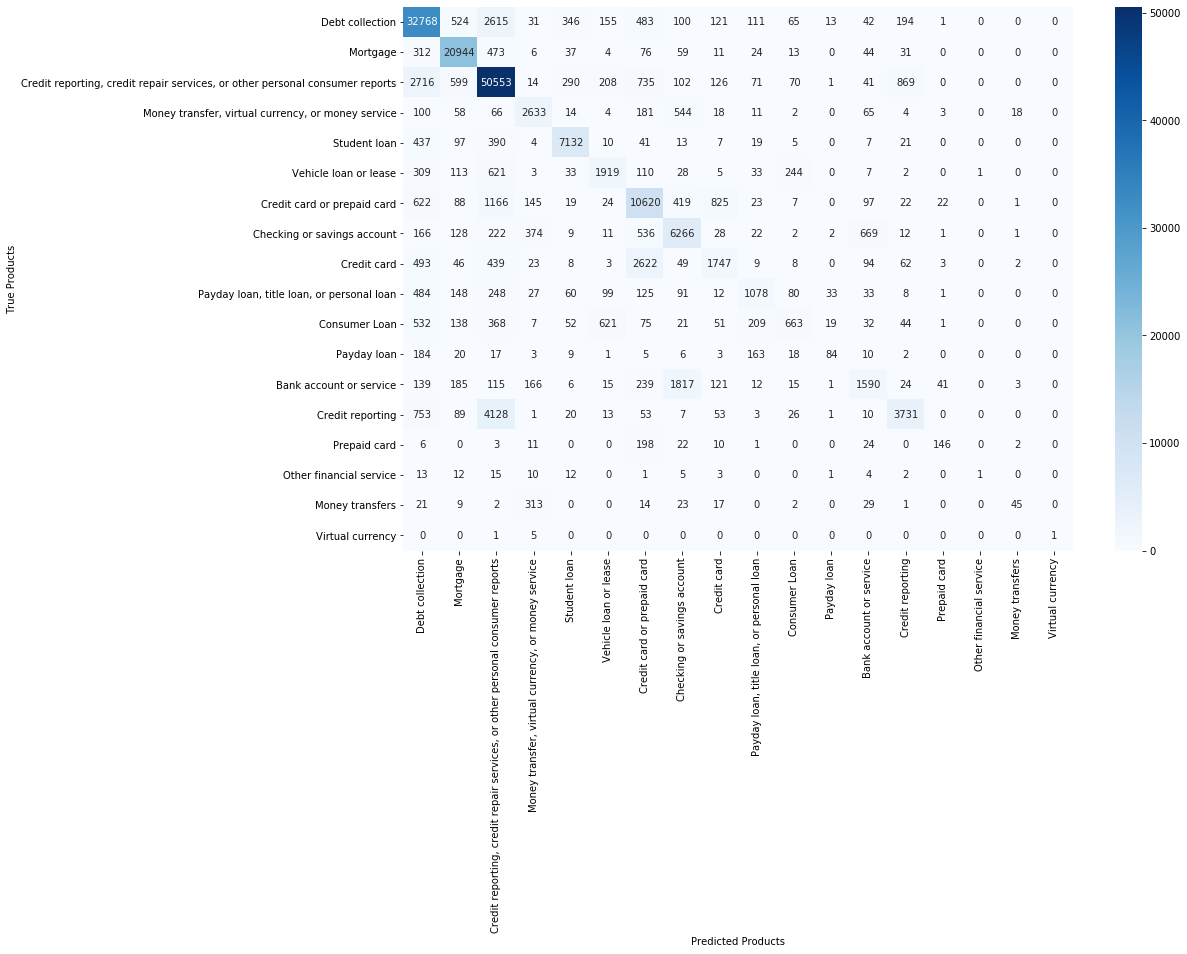

In [7]:
#show visualizations inline with code cells
%matplotlib inline
#create confusion matrix
array = confusion_matrix(y_test, y_pred)
#define plot region
fig, ax = plt.subplots(figsize=(15,10))
#create heatmap from confusion matrix
sns.heatmap(array,
            annot=True,
            fmt='d',
            xticklabels=product_id_df.Product.values,
            yticklabels=product_id_df.Product.values, 
            cmap=plt.cm.Blues)
plt.ylabel('True Products')
plt.xlabel('Predicted Products')
plt.show()